In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma, rgamma
from scipy import integrate

## Monte Carlo Methods: Integration

The problem of dealing with high dimensional spaces is common to all kinds of situations, from machine learning to basic integration. We haven't encountered this problem directly so far because we have been using small numbers of parameters.  In discussing Bayesian inference, we were mostly talking about 1 ro 2 parameters at a time. But we saw in the case of solve differential equations with machine learning how quickly the number of parameters would grow. Our intuition for how do deal with such high dimensional spaces is generally quite bad.

Recall that one task we might want to perform on in this parameter space is integration.  Concretely, I need to integrate over some parameters to marginalize over their uncertainty.  While easy to state, numerically integrating in high dimensional spaces is very difficult and is a window in the broader challenges one can encounter.  

To see the problem, let's remember that the volume of a d-dimensional ball of radius 1 is 
$$ V_d = \frac{\pi^{d/2}}{ \Gamma[\frac{d}{2}+1]}$$
However, if we stick this sphere inside a d-dimensional box where the sphere touches the edges, so that each length of the box is the diameter, 2, then the volume of the enclosing box is $2^d$

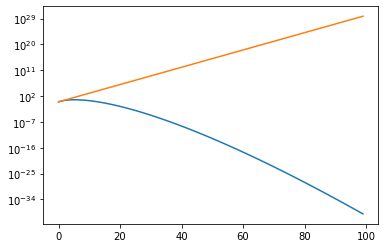

In [2]:
dlist=np.arange(100)
plt.plot(dlist,np.pi**(dlist/2.)/gamma(dlist/2.+1.))
plt.plot(dlist,2.**(dlist))
plt.yscale('log')

In [3]:
def V_ratio(d):
    return np.pi**(d/2.)/(2**(d)*gamma(d/2.+1.))

In [4]:
print(V_ratio(3),V_ratio(10),V_ratio(20),V_ratio(100))

0.5235987755982989 0.00249039457019272 2.461136950494199e-08 1.8681820538375912e-70


In short, by the time you reach 100 dimensional space, the fraction of the volume taken up by our sphere is 10**(-70) of th total volume. 

So now imagine I have a function that falls off like an exponential of the distance from the origin.  The support of this function is going to be limited to a tiny fraction of the volume.  So if I am trying to integrate this function, if I put it inside a d-dimensional grid and integrate as usual, I am going to spend all my time adding up exponentially small terms and I will miss the region where the integrand gets it support.

To see this, let's imagein trying to determine the volume of the 4-sphere using nquad integration

In [5]:
def S2(x1,x2):
    out=0
    if (x1**2+x2**2)<=1.:
        out=1.
    return out
def S3(x1,x2,x3):
    out=0
    if (x1**2+x2**2+x3**2)<=1.:
        out=1.
    return out

In [6]:
integrate.nquad(lambda x: x,[[0,1]])

(0.5, 5.551115123125783e-15)

In [7]:
integrate.nquad(S2,[[-1,1],[-1,1]])

/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


(3.1421278363209537, 0.0002045333175209052)

In [8]:
integrate.dblquad(S2,-1,1,lambda x:-1,lambda x:1)

(3.1421278363209537, 0.0002045333175209052)

This is already quite slow.  This is in part because of how we defined the function, so instead lets try using a built in numpy function that might work faster.  So let's look some simple integrals as a function of dimension:  

In [9]:
integrate.nquad(lambda x,y,z,a:np.exp(-x**2-y**2-z**2-a**2),[[-1,1],[-1,1],[-1,1],[-1,1]])

(4.977294701166025, 5.5259071775793096e-14)

In [10]:
import time

In [11]:
t0 = time.time()
integrate.nquad(lambda x,y,z:np.exp(-x**2-y**2-z**2),[[-1,1],[-1,1],[-1,1]])
t3=time.time() - t0
print(t3)

0.014984130859375


In [12]:
t0 = time.time()
integrate.nquad(lambda x,y,z,a:np.exp(-x**2-y**2-z**2-a**2),[[-1,1],[-1,1],[-1,1],[-1,1]])
t4=time.time() - t0
print(t4)

0.3367133140563965


In [13]:
t0 = time.time()
integrate.nquad(lambda x,y,z,a,b:np.exp(-x**2-y**2-z**2-a**2-b**2),[[-1,1],[-1,1],[-1,1],[-1,1],[-1,1]])
t5=time.time() - t0
print(t5)

7.138036012649536


It is costing us 20 times the speed whenever we increase dimension by one.  So the running time is ${\cal O}(20^d)$.  Clearly we will have no hope if we want to work in some high dimensional space.

**Why might it be good to use random numbers to integrate?** Random numbers are better than evenly space sampling because we don't actually know where our signal lives. When you are looking for a signal in a unknown space, doing something in a very correlated way is not a good search strategy.  Random means that there is at least some chance you will hit on the right answer.  In contrast, trying a regular grid may make your probability zero because your signal lives between the grid points.

Let's start by implement the most basic possible version of monte-carlo integration just to find the volume of the $d$-sphere. Here we are simple going to sample $d$ numbers between -1 and 1 and calculate the fraction inside the $d$-sphere.  Finally, the area is $2^d$ (the volume of the box) tims this fraction.

As we have already done this before to determine $\pi$ ($d=2$), we are going to go straight to comparing with the actual answer.  We will output the answer after every 100 points so that we can check how quickly we are approaching the answer

In [14]:
def dvol(n,d):
    analytic=np.pi**(float(d)/2.)*rgamma(float(d)/2.+1)
    count = 0
    Narea=[]
    x=np.zeros(d)
    for j in range(n):
        #sample x_i from -1 to 1
        for i in range(d):
            x[i]=2.* random.random()-1.
        if (x*x).sum()<=1:
            count += 1.
        #only add the result if it is inside the cicle
        if j%100 ==0 and j!=0:  # Now ouput the result every 100 steps
            Narea.append((np.abs(2**(d)*float(count)/float(j)-analytic))/analytic)
    
    return Narea

In [15]:
Narea={}
for i in range(4):
    t0 = time.time()
    Narea[i]=dvol(10**6,i+2)
    print(time.time()-t0)

4.035202741622925


4.47490382194519


4.589968204498291


4.852510929107666


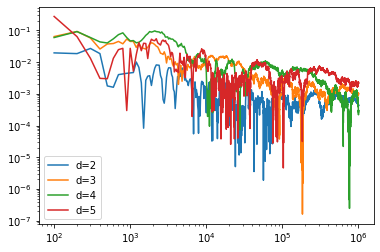

In [16]:
points=100*(np.arange(len(Narea[0]))+1)
for i in range(4):
    plt.plot(points,Narea[i],label='d='+str(i++2))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

Here we are getting the same level of fractional error for approximately the same computing time as we increase dimension.

However, we do note that the error is getting worse with dimension. This is not just random, at some point we are going to encounter our original problem: we are drawing numbers uniformly inside a $d$-dimensional box and keeping track of those that are inside the sphere.  However, but we say at $d=20$, the fraction of volume in the sphere is about $2.5\times10^{-8}$ and therefore we wouldn't expect to hit the sphere once in $10^6$ tries.

## Importance Sampling

Of course, what we are really enountering is the idea random numbers can't solve the volume problem if we are drawing from a uniform distribution.  Instead, we should be tailoring how to draw the random numbers to the problem we are trying to solve.

We are going to try a very basic technique called importance sampling. This will give us some intuition but will miss out of some of the complexity of more powerful tools.

However, the key idea that is common to all of them is that we have a probability distribution that allows us to increase the chance of finding the most important parts of parameter space.  In advanced techniques, this probabilty adjust to the function itself, allowing it to find the highest points more easily.  Here is will simply choose one and see how to tell when we've made a good choice.

Importance sampling is the generalization of the above when we don't pick a uniform distribution.  Suppose instead that a pick points from a  distribution $p(x)$ and I want to compute $\int d^d x q(\vec x) p(\vec x) = \langle q(\vec x) \rangle$.  Now if we define $q(\vec x) = f(\vec x) / p(\vec x)$ this is also equivalent to $\int d^d x f(\vec x) \equiv Q$.  Now we draw from the distribution $p(\vec x)$ we get
$$
Q_N = V \frac{1}{N} \sum_{i =1}^{N} q(\vec x_i) 
$$
where $\vec x_i$ are drawn from $p(\vec x)$ then we again have $Q_N \to Q$.  As long as $p(\vec x)$ and $q(\vec x)$ can be chosen to that they are large in the same areas, we might expect to find faster convergence to the correct answer.

Let's start by recalculating the volume of the sphere.  We are going to have $p(\vec x) = e^{-|\vec x|^2/(2 \sigma^2)}/\sqrt{2\pi \sigma^2}$ and $f(\vec x)=1$ where $x^2 \leq 1$ and 0 otherwise and therefore $q(\vec x) = f(\vec x) / p(\vec x)$ is $1/p(\vec x_i)$ when $\vec x_i$ is inside the sphere and 0 otherwise.

In [17]:
# We are going to pick from a gaussian distribution with some variance
def gaussvol(n,d,sigma):
    analytic=np.pi**(float(d)/2.)*rgamma(float(d)/2.+1)
    count = 0
    Narea=[]
    x=np.zeros(d)
    for j in range(n):
        random.seed()
        #sample x_i from -1 to 1
        for i in range(d):
            x[i]=np.random.randn()*sigma     
        if (x*x).sum()<=1:
            # Here we use importance sampling to weight the result
            count+= np.sqrt(2*np.pi*sigma**2)**(d)*np.exp((x*x).sum()/(2.*sigma**2))
        #only add the result if it is inside the cicle
        if j%1000 ==0 and j!=0:
            Narea.append(np.abs(float(count)/float(j)-analytic)/analytic)
    
    return Narea

In [18]:
npoints=10000
dim=int(6)
gaussvol(npoints,dim,1)
#sigma_list=[5,1,0.5,0.3,0.2,0.1]
#Gvol={}
#for s in sigma_list:
#    Gvol[s]=gaussvol(npoints,dim,s)
#vol6flat=dvol(npoints,dim)


[0.04149003030657933,
 0.07782461770088567,
 0.07023623047824133,
 0.11709683655490448,
 0.18652270124630127,
 0.17931501864753782,
 0.17172442937057006,
 0.1319520364669321,
 0.11704453450558922]

In [19]:
# We are going to pick from a gaussian distribution with some variance
def gaussvol_fast(n,d,sigma):
    analytic=np.pi**(float(d)/2.)*rgamma(float(d)/2.+1)
    count = 0
    Narea=[]
    X=(np.random.randn(d*n)*sigma).reshape(n,d)
    Y=((X**2).sum(axis=1))
    f=1000
    factor=int(n/f)
    out=np.zeros(factor)
    for i in range(factor):
        out[i]=np.abs(((Y[:(i+1)*f]<=1)*np.exp(Y[:(i+1)*f]/(2*sigma**2))).sum()*np.sqrt(2*np.pi*sigma**2)**d/((i+1)*f)-analytic)/analytic
    #return ((Y<=1)*np.exp(Y)).sum()/n
    return out

In [20]:
npoints=1000000
dim=int(6)
sigma_list=[0.6,0.4,0.2]
Gvol={}
for s in sigma_list:
    Gvol[s]=gaussvol_fast(npoints,dim,s)
vol6flat=dvol(npoints,dim)

KeyboardInterrupt: 

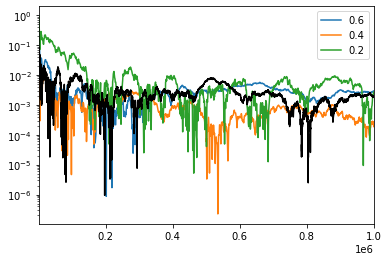

In [23]:
Num=np.arange(1000,npoints+1000,step=1000)
n_old=np.arange(100,npoints,step=100)
for s in sigma_list:
    plt.plot(Num,Gvol[s],label=str(s))
plt.plot(n_old,vol6flat,color='black')
plt.yscale('log')
#plt.xscale('log')
plt.legend()
plt.xlim(1000,npoints)
plt.show()

The first thing we notice is that for the same number of randomly drawn points, some of our Gaussian models are doing quite a bit better than our black line which used a uniform distribution.

The second, and more important, thing to notice that the accuracy is not strictly decreasing or increasing.  The best choice was 0.4, both 0.2 and 0.6 had larger errors.  This is pretty easy to understand if we keep track of how often we are throwing away points:

In [24]:
# We are going to pick from a gaussian distribution with some variance
def gaussvol_frac(n,d,sigma):
    analytic=np.pi**(float(d)/2.)*rgamma(float(d)/2.+1)
    count = 0
    Narea=[]
    X=(np.random.randn(d*n)*sigma).reshape(n,d)
    Y=((X**2).sum(axis=1))

    out_Vol=np.abs(((Y<=1)*np.exp(Y/(2*sigma**2))).sum()*np.sqrt(2*np.pi*sigma**2)**d/(n)-analytic)/analytic
    out_frac=(Y<=1).sum()/n
    return out_Vol,out_frac

In [25]:
s_r=np.logspace(-2,0.5,40)
error=np.zeros(len(s_r))
frac=np.zeros(len(s_r))
for i in range(len(s_r)):
    error[i],frac[i]=gaussvol_frac(npoints,dim,s_r[i])

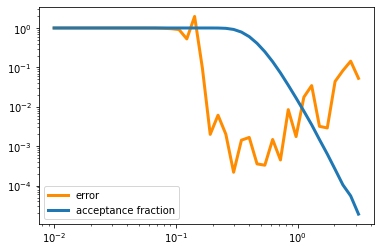

In [26]:
plt.plot(s_r,error,color='darkorange',lw=3,label='error')
plt.plot(s_r,frac,lw=3,label='acceptance fraction')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

Here we see what's going on: when $\sigma < 0.1$, basically every point is inside the sphere.  The fraction of points that pass $\vec x^2\leq 1$ is basically 100 percent, but that means out poitns are not really sampling the shape of the function $f(x)$.  When $\sigma > 1$ almost none of the points are passing the test and so our error also increases because we don't have enough points.  

This is the basic moral of monte carlo methods: they can be much more effective than other techniques, but the parameters of the probability distribution have to encode some knowledge of the function.  There are lots of scheme that use the idea of throwing away random number that aren't in some range, and what we learned here is that you are trying to find a sweet spot between never throwing away your trails and always throwing them away.

In [27]:
print(gaussvol_frac(npoints,10,0.5))
print(gaussvol_frac(npoints,20,0.25))
print(gaussvol_frac(npoints,50,0.15))

(7.483769599341911e-05, 0.052534)
(0.0010311414444701885, 0.283449)
(0.0026357558160213456, 0.304265)


But look at what we can do with this: we are calculating integration in 50 dimensions in seconds so 1/1000 accuracy.  This would have been impossible the way we had started.

#### Application to a Generic Integral

Now we want to do more than just calculate the volume but think about calculating an actual integral.  Well, luckily enough for us, we have already done most of the work.  If we define a function that takes a shape $(n,d)$ array and returns a length n array, then we can easily add it to the function we already have.

Remember $f(x)$ was just implemented by the bool $Y<=1$. To make this an integral over a number function, we just swapm that piece for our functionf

In [28]:
def gauss_int(f,n,d,sigma):
    X=(np.random.randn(d*n)*sigma).reshape(n,d)
    Y=((X**2).sum(axis=1))

    out_int=(f(X)*np.exp(Y/(2*sigma**2))).sum()*np.sqrt(2*np.pi*sigma**2)**d/(n)
    out_frac=(Y<=1).sum()/n
    return out_int,out_frac

As long as the function is define as describe, this will work. A simple example might be

In [29]:
def radial_func(X):
    z=(X**2).sum(axis=1)
    return np.sin(0.2*z)*np.exp(-z)

In [30]:
gauss_int(radial_func,10000000,6,0.5)

(16.366023429849886, 0.3230563)

We see there is really no problem with the speed of this method.  Our real challenge becomes how we test the accuracy.  Since part of the challege is picking the parameters that best suite the integral, we can't rely on knowing the exact answer (otherwise why are we doing the integral!). Some basic things we can do are check convergence and sensitivity to parameters

In [31]:
print(gauss_int(radial_func,100000,6,0.5))
print(gauss_int(radial_func,1000000,6,0.5))
print(gauss_int(radial_func,10000000,6,0.5))

(16.238085410897224, 0.32452)
(16.170245937619843, 0.323394)
(16.272515275174765, 0.3232996)


In [32]:
int_val=np.zeros(len(s_r))
int_frac=np.zeros(len(s_r))
for i in range(len(s_r)):
    int_val[i],int_frac[i]=gauss_int(radial_func,1000000,6,s_r[i])

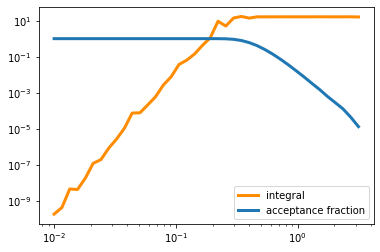

In [33]:
plt.plot(s_r,int_val,color='darkorange',lw=3,label='integral')
plt.plot(s_r,int_frac,lw=3,label='acceptance fraction')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

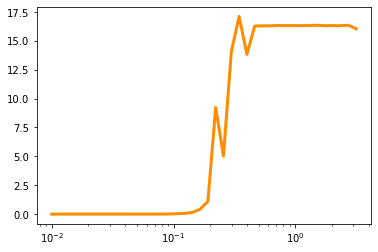

In [34]:
plt.plot(s_r,int_val,color='darkorange',lw=3,label='integral')
#plt.plot(s_r,int_frac,lw=3,label='acceptance fraction')
#plt.legend()
#plt.yscale('log')
plt.xscale('log')
plt.show()

## Summary

There are a wide range of numerical methods that use random numbers to speed up and/or improve the accuracy of the method.  This is particularly important for problems with nots of parameters where uniform sampling becomes extremely inefficient.  We studied the case of integration specifically, which shows many of the pros and cons of these methods in a context that is easy enough to understand.